In [ ]:
import re
import pandas as pd
import csv
import numpy as np
from collections import Counter
import nltk
import random
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import IsolationForest
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings

warnings.filterwarnings(action = 'ignore')
import gensim
from gensim.models import Word2Vec

In [ ]:
import tensorflow as tf
import math
import os
import time
import numpy as np
import pandas as pd
import random
import statistics
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential, regularizers
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Input, LSTM, Dropout, TimeDistributed, RepeatVector, Bidirectional
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredLogarithmicError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy, Precision, AUC, Recall
from sklearn.metrics import silhouette_score

In [ ]:
pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.9-py3-none-any.whl size=184097 sha256=42b6c3c889d9d436616a558dfd4dfebcec1984d385322384c432b180de61bfa9
  Stored in directory: /root/.cache/pip/wheels/83/55/6b/552e083cf5509c0afe808b76cf434f1be284d01a112623bd37
Successfully built pyod


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_outlier = pd.read_csv('/content/drive/MyDrive/thesis/val/raw_val_all.csv', sep=',')

In [ ]:
df_validate = pd.read_csv('/content/drive/MyDrive/thesis/val/raw_val.csv', sep=',')

In [ ]:
true_labels = df_outlier.label


oh

In [ ]:
df_oh = pd.read_csv('/content/drive/MyDrive/thesis/train/oh_data.csv', sep=',')
x_out_oh = pd.read_csv('/content/drive/MyDrive/thesis/val/val-x_out_oh.csv', sep=',')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()
x_scaled_cv = mm_scaler.fit_transform(df_oh)

In [ ]:
x_out_cv = mm_scaler.transform(x_out_oh)

In [ ]:
test = df_oh[:int(split_len)]
train = df_oh[int(split_len):]

In [ ]:
x_train = train.values.reshape(train.shape[0], 1, train.shape[1])
x_test = test.values.reshape(test.shape[0], 1,train.shape[1])

x_out = x_out_cv.reshape(x_out_cv.shape[0], 1,x_out_cv.shape[1])

#define the model

def autoencoder_model(X):

  inputs = Input(shape=(X.shape[1], X.shape[2]))
  L1 = Bidirectional(LSTM(128, activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00)))(inputs)
  L2 = Bidirectional(LSTM(64, activation='relu', return_sequences=False))(L1)
  L3 = RepeatVector(X.shape[1])(L2)
  L4 = Bidirectional(LSTM(64, activation='relu', return_sequences=True))(L3)
  L5 = Bidirectional(LSTM(128, activation='relu', return_sequences=True))(L4)
  output = TimeDistributed(Dense(X.shape[2]))(L5)
  model = Model(inputs=inputs, outputs=output)
  return model

# create the autoencoder model
model = autoencoder_model(x_train)
model.compile(optimizer='adam', loss=['mse'],
              metrics=['mae', 'acc', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
model.summary()

nb_epochs = 10
batch_size = 1000
history = model.fit(x_train, x_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.15).history





Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 518)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 256)           662528    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 repeat_vector (RepeatVector  (None, 1, 128)           0         
 )                                                               
                                                                 
 bidirectional_2 (Bidirectio  (None, 1, 128)           98816     
 nal)                                                        

In [ ]:
# calculate the loss on the test set
X_pred = model.predict(x_out)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=x_out_oh.columns)
X_pred.index = x_out_oh.index

scored = pd.DataFrame(index=x_out_oh.index)
Xtest = x_out.reshape(x_out_oh.shape[0], x_out.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.0006
scored['Anomaly'] = np.where(scored['Loss_mae'] > scored['Threshold'], -1, 1)
scored.head()
test_pred = scored.Anomaly

from sklearn.metrics import classification_report
print(classification_report(true_labels, test_pred))

In [ ]:
from pyod.models.copod import COPOD
if __name__ == "__main__":

    # train COPOD detector
    clf_name = 'COPOD'
    clf = COPOD(contamination=0.06)

    # you could try parallel version as well.
    # clf = COPOD(n_jobs=2)
    clf.fit(train)
    pred_test = clf.predict(x_out_cv_scale)

if (pred_test == 1).any():
    pred_test[pred_test == 1] = -1

if (pred_test == 0).any():
    pred_test[pred_test == 0] = 1

Counter(pred_test)

from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_test))

              precision    recall  f1-score   support

          -1       0.29      0.56      0.38      3737
           1       0.98      0.95      0.96     98263

    accuracy                           0.93    102000
   macro avg       0.64      0.75      0.67    102000
weighted avg       0.96      0.93      0.94    102000



RErun with lower contam

In [ ]:
from pyod.models.ecod import ECOD
if __name__ == "__main__":

    # train COPOD detector
    clf_name = 'ECOD'
    clf = ECOD(contamination=0.015)

    # you could try parallel version as well.
    # clf = COPOD(n_jobs=2)
    clf.fit(train)
    pred_test = clf.predict(x_out_cv_scale)

if (pred_test == 1).any():
    pred_test[pred_test == 1] = -1

if (pred_test == 0).any():
    pred_test[pred_test == 0] = 1

Counter(pred_test)

from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_test))

              precision    recall  f1-score   support

          -1       0.55      0.54      0.54      3737
           1       0.98      0.98      0.98     98263

    accuracy                           0.97    102000
   macro avg       0.76      0.76      0.76    102000
weighted avg       0.97      0.97      0.97    102000



In [ ]:
Counter(pred_test)

Counter({1: 94819, -1: 7181})

In [ ]:
clf = IsolationForest(n_estimators=200, contamination = 0.045)

In [ ]:
clf_if_cv = clf.fit(train)

In [ ]:
from joblib import dump, load

# save the model
dump(clf_if_cv,'/content/drive/MyDrive/thesis/models/iforest/clf_if_oh.joblib')

['/content/drive/MyDrive/thesis/models/iforest/clf_if_oh.joblib']

In [ ]:
from joblib import dump, load
clf_if_cv = load('/content/drive/MyDrive/thesis/models/iforest/clf_if_oh.joblib')

In [ ]:
pred_test = clf_if_cv.predict(x_out_cv_scale)

In [ ]:
Counter(pred_test)

Counter({1: 96791, -1: 5209})

In [ ]:
true_labels = df_outlier.label

In [ ]:
df_validate['label'] = pred_test

In [ ]:
df_validate[df_validate['label'] == -1].to_csv('/content/drive/MyDrive/thesis/models/iforest/oh_results_val.csv', index=False)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_test))

              precision    recall  f1-score   support

          -1       0.57      0.80      0.67      3737
           1       0.99      0.98      0.98     98263

    accuracy                           0.97    102000
   macro avg       0.78      0.89      0.83    102000
weighted avg       0.98      0.97      0.97    102000



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have the true labels for the dataset in 'true_labels' and the LOF predictions in 'lof_predictions'

# Convert LOF scores to binary labels based on a threshold (e.g., outliers with scores above the threshold are considered anomalies)

# Calculate accuracy
accuracy = accuracy_score(true_labels, pred_test)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_labels, pred_test)
print("Precision:", precision)

# Calculate recall
recall = recall_score(true_labels, pred_test)
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(true_labels, pred_test)
print("F1 Score:", f1)

Accuracy: 0.9709607843137255
Precision: 0.9923030033784133
Recall: 0.9774380997934116
F1 Score: 0.9848144616362648


OH+PCA

In [ ]:
df_oh = pd.read_csv('/content/drive/MyDrive/thesis/train/reduce_pca_oh.csv', sep=',')
x_out_oh = pd.read_csv('/content/drive/MyDrive/thesis/val/val-reduce_pca_oh.csv', sep=',')

In [ ]:
df_oh.head(5)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.509693e-14,0.238324,0.545315,0.216244,0.469836,0.300938,0.046486,0.212128,0.251039,0.391628,...,0.236483,0.329686,0.367512,0.204161,0.162650,0.234812,0.206663,0.184946,0.436846,0.393811
1,0.000000e+00,0.238324,0.545315,0.216244,0.469836,0.300938,0.046486,0.212128,0.251039,0.391628,...,0.236483,0.329686,0.367512,0.204161,0.162650,0.234812,0.206663,0.184946,0.436846,0.393811
2,0.000000e+00,0.238324,0.545315,0.216244,0.469836,0.300938,0.046486,0.212128,0.251039,0.391628,...,0.236483,0.329686,0.367512,0.204161,0.162650,0.234812,0.206663,0.184946,0.436846,0.393811
3,0.000000e+00,0.238324,0.545315,0.216244,0.469836,0.300938,0.046486,0.212128,0.251039,0.391628,...,0.236483,0.329686,0.367512,0.204161,0.162650,0.234812,0.206663,0.184946,0.436846,0.393811
4,3.114342e-02,0.460248,0.000670,0.228479,0.464283,0.300577,0.045348,0.212277,0.250890,0.392299,...,0.236517,0.328604,0.367529,0.204128,0.162696,0.234831,0.206919,0.184032,0.436838,0.393797


In [ ]:
test = df_oh[:int(split_len)]
train = df_oh[int(split_len):]

In [ ]:
x_train = train.values.reshape(train.shape[0], 1, train.shape[1])
x_test = test.values.reshape(test.shape[0], 1,train.shape[1])

x_out = x_out_oh.values.reshape(x_out_oh.shape[0], 1,x_out_oh.shape[1])

#define the model

def autoencoder_model(X):

  inputs = Input(shape=(X.shape[1], X.shape[2]))
  L1 = Bidirectional(LSTM(128, activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00)))(inputs)
  L2 = Bidirectional(LSTM(64, activation='relu', return_sequences=False))(L1)
  L3 = RepeatVector(X.shape[1])(L2)
  L4 = Bidirectional(LSTM(64, activation='relu', return_sequences=True))(L3)
  L5 = Bidirectional(LSTM(128, activation='relu', return_sequences=True))(L4)
  output = TimeDistributed(Dense(X.shape[2]))(L5)
  model = Model(inputs=inputs, outputs=output)
  return model


# create the autoencoder model
model = autoencoder_model(x_train)
model.compile(optimizer='adam', loss=['mse'],
              metrics=['mae', 'acc', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
model.summary()

nb_epochs = 10
batch_size = 1000
history = model.fit(x_train, x_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.15).history





Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 25)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 256)           157696    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 repeat_vector (RepeatVector  (None, 1, 128)           0         
 )                                                               
                                                                 
 bidirectional_2 (Bidirectio  (None, 1, 128)           98816     
 nal)                                                        

22335/22335 [==============================] - 75s 3ms/step


<ipython-input-9-75a6f4c073f7>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mse'], bins = 20, kde= True, color = 'blue');


(0.0, 0.5)

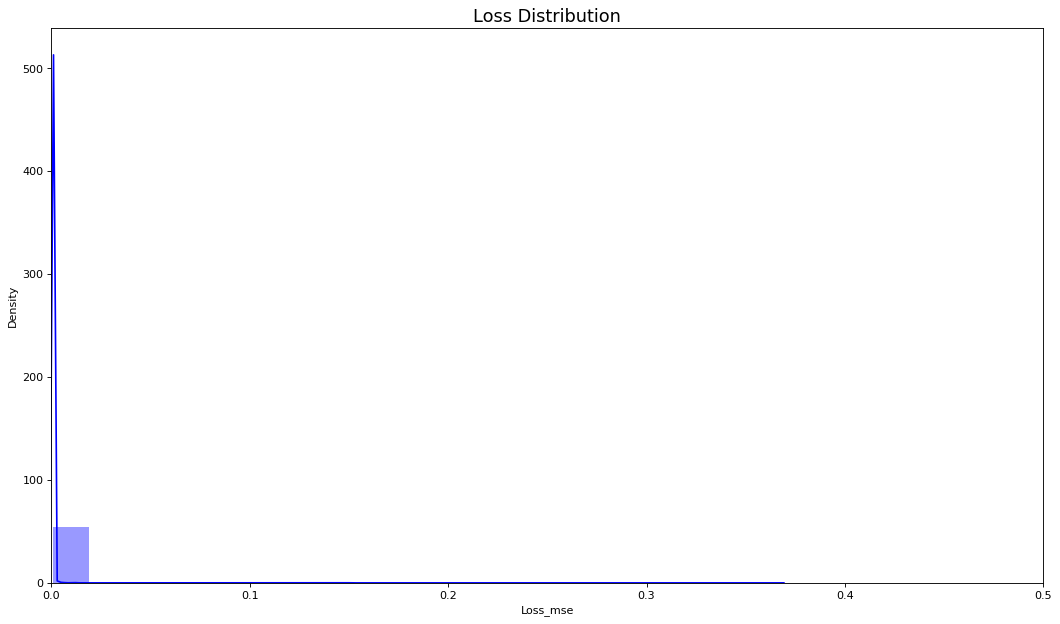

In [ ]:
# plot the loss distribution of the training set
X_pred = model.predict(x_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = x_train.reshape(x_train.shape[0], x_train.shape[2])
scored['Loss_mse'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mse'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [ ]:
# calculate the loss on the test set
X_pred = model.predict(x_out)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=x_out_oh.columns)
X_pred.index = x_out_oh.index

scored = pd.DataFrame(index=x_out_oh.index)
Xtest = x_out.reshape(x_out_oh.shape[0], x_out.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.07
scored['Anomaly'] = np.where(scored['Loss_mae'] > scored['Threshold'], -1, 1)
scored.head()
test_pred = scored.Anomaly

from sklearn.metrics import classification_report
print(classification_report(true_labels, test_pred))

3188/3188 [==============================] - 11s 3ms/step
              precision    recall  f1-score   support

          -1       1.00      0.54      0.70      3737
           1       0.98      1.00      0.99     98263

    accuracy                           0.98    102000
   macro avg       0.99      0.77      0.84    102000
weighted avg       0.98      0.98      0.98    102000



In [ ]:
from pyod.models.copod import COPOD
if __name__ == "__main__":

    # train COPOD detector
    clf_name = 'COPOD'
    clf = COPOD(contamination=0.04)

    # you could try parallel version as well.
    # clf = COPOD(n_jobs=2)
    clf.fit(train)
    pred_test = clf.predict(x_out_oh)

if (pred_test == 1).any():
    pred_test[pred_test == 1] = -1

if (pred_test == 0).any():
    pred_test[pred_test == 0] = 1

Counter(pred_test)

from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_test))

              precision    recall  f1-score   support

          -1       0.41      1.00      0.58      3737
           1       1.00      0.95      0.97     98263

    accuracy                           0.95    102000
   macro avg       0.70      0.97      0.78    102000
weighted avg       0.98      0.95      0.96    102000



In [ ]:
Counter(pred_test)

Counter({1: 97031, -1: 4969})

In [ ]:
from pyod.models.ecod import ECOD
if __name__ == "__main__":

    # train COPOD detector
    clf_name = 'ECOD'
    clf = ECOD(contamination=0.020)

    # you could try parallel version as well.
    # clf = COPOD(n_jobs=2)
    clf.fit(train)
    pred_test = clf.predict(x_out_oh)

if (pred_test == 1).any():
    pred_test[pred_test == 1] = -1

if (pred_test == 0).any():
    pred_test[pred_test == 0] = 1

Counter(pred_test)

from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_test))

              precision    recall  f1-score   support

          -1       0.58      1.00      0.74      3737
           1       1.00      0.97      0.99     98263

    accuracy                           0.97    102000
   macro avg       0.79      0.99      0.86    102000
weighted avg       0.98      0.97      0.98    102000



In [ ]:
Counter(pred_test)

Counter({1: 95597, -1: 6403})

In [ ]:
clf = IsolationForest(n_estimators=200, contamination = 0.045)

In [ ]:
clf_if_cv = clf.fit(train)

In [ ]:
from joblib import dump, load

# save the model
dump(clf_if_cv,'/content/drive/MyDrive/thesis/models/iforest/clf_if_oh_pca.joblib')

['/content/drive/MyDrive/thesis/models/iforest/clf_if_oh_pca.joblib']

In [ ]:
from joblib import dump, load
clf_if_cv = load('/content/drive/MyDrive/thesis/models/iforest/clf_if_oh_pca.joblib')

In [ ]:
pred_test = clf_if_cv.predict(x_out_oh)

In [ ]:
Counter(pred_test)

Counter({1: 95642, -1: 6358})

In [ ]:
true_labels = df_outlier.label

In [ ]:
df_validate['label'] = pred_test

In [ ]:
df_validate[df_validate['label'] == -1].to_csv('/content/drive/MyDrive/thesis/models/iforest/oh_results_pca_val.csv', index=False)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_test))

              precision    recall  f1-score   support

          -1       0.59      1.00      0.74      3737
           1       1.00      0.97      0.99     98263

    accuracy                           0.97    102000
   macro avg       0.79      0.99      0.86    102000
weighted avg       0.98      0.97      0.98    102000



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have the true labels for the dataset in 'true_labels' and the LOF predictions in 'lof_predictions'

# Convert LOF scores to binary labels based on a threshold (e.g., outliers with scores above the threshold are considered anomalies)

# Calculate accuracy
accuracy = accuracy_score(true_labels, pred_test)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_labels, pred_test)
print("Precision:", precision)

# Calculate recall
recall = recall_score(true_labels, pred_test)
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(true_labels, pred_test)
print("F1 Score:", f1)

Accuracy: 0.9743039215686274
Precision: 1.0
Recall: 0.9733266845099376
F1 Score: 0.9864830716072303


oh+ae

In [ ]:
df_oh = pd.read_csv('/content/drive/MyDrive/thesis/train/reduce_ae_oh_data.csv', sep=',')
x_out_oh = pd.read_csv('/content/drive/MyDrive/thesis/val/val-reduce_ae_oh_data.csv', sep=',')

In [ ]:
df_oh.head(5)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,0.0,0.793297,0.870673,0.000000,0.269481,1.0,0.000000,0.00000,0.288325,...,0.0,0.341931,0.785103,0.0,0.000000,0.0,0.00000,0.845033,0.446104,0.000000
1,0.0,0.0,0.793297,0.870673,0.000000,0.269481,1.0,0.000000,0.00000,0.288325,...,0.0,0.341931,0.785103,0.0,0.000000,0.0,0.00000,0.845033,0.446104,0.000000
2,0.0,0.0,0.793297,0.870673,0.000000,0.269481,1.0,0.000000,0.00000,0.288325,...,0.0,0.341931,0.785103,0.0,0.000000,0.0,0.00000,0.845033,0.446104,0.000000
3,0.0,0.0,0.793297,0.870673,0.000000,0.269481,1.0,0.000000,0.00000,0.288325,...,0.0,0.341931,0.785103,0.0,0.000000,0.0,0.00000,0.845033,0.446104,0.000000
4,0.0,0.0,0.966923,0.971163,0.603218,0.000000,0.0,0.344905,0.41562,0.197291,...,0.0,0.976638,0.972849,0.0,0.712611,0.0,0.22213,0.965408,0.984466,0.649624


In [ ]:
df_oh.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31'],
      dtype='object')

In [ ]:
column_name = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31']

In [ ]:
x_out_oh.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31'],
      dtype='object')

In [ ]:
x_out_oh.columns = column_name

In [ ]:
x_out_oh.head(5)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,0.0,0.793297,0.870673,0.000000,0.269481,1.0,0.000000,0.00000,0.288325,...,0.0,0.341931,0.785103,0.0,0.000000,0.0,0.00000,0.845033,0.446104,0.000000
1,0.0,0.0,0.793297,0.870673,0.000000,0.269481,1.0,0.000000,0.00000,0.288325,...,0.0,0.341931,0.785103,0.0,0.000000,0.0,0.00000,0.845033,0.446104,0.000000
2,0.0,0.0,0.793297,0.870673,0.000000,0.269481,1.0,0.000000,0.00000,0.288325,...,0.0,0.341931,0.785103,0.0,0.000000,0.0,0.00000,0.845033,0.446104,0.000000
3,0.0,0.0,0.793297,0.870673,0.000000,0.269481,1.0,0.000000,0.00000,0.288325,...,0.0,0.341931,0.785103,0.0,0.000000,0.0,0.00000,0.845033,0.446104,0.000000
4,0.0,0.0,0.966923,0.971163,0.603218,0.000000,0.0,0.344905,0.41562,0.197291,...,0.0,0.976638,0.972849,0.0,0.712611,0.0,0.22213,0.965408,0.984466,0.649624


In [ ]:
split_len = 0.3 * len(df_oh)
split_len

306302.7

In [ ]:
test = df_oh[:int(split_len)]
train = df_oh[int(split_len):]

In [ ]:
x_train = train.values.reshape(train.shape[0], 1, train.shape[1])
x_test = test.values.reshape(test.shape[0], 1,train.shape[1])

x_out = x_out_oh.values.reshape(x_out_oh.shape[0], 1,x_out_oh.shape[1])

#define the model
def autoencoder_model(X):

  inputs = Input(shape=(X.shape[1], X.shape[2]))
  L1 = Bidirectional(LSTM(128, activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00)))(inputs)
  L2 = Bidirectional(LSTM(64, activation='relu', return_sequences=False))(L1)
  L3 = RepeatVector(X.shape[1])(L2)
  L4 = Bidirectional(LSTM(64, activation='relu', return_sequences=True))(L3)
  L5 = Bidirectional(LSTM(128, activation='relu', return_sequences=True))(L4)
  output = TimeDistributed(Dense(X.shape[2]))(L5)
  model = Model(inputs=inputs, outputs=output)
  return model


# create the autoencoder model
model = autoencoder_model(x_train)
model.compile(optimizer='adam', loss=['mse'],
              metrics=['mae', 'acc', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
model.summary()

nb_epochs = 10
batch_size = 1000
history = model.fit(x_train, x_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.15).history

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1, 32)]           0         
                                                                 
 lstm_12 (LSTM)              (None, 1, 128)            82432     
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 repeat_vector_3 (RepeatVect  (None, 1, 64)            0         
 or)                                                             
                                                                 
 lstm_14 (LSTM)              (None, 1, 64)             33024     
                                                                 
 lstm_15 (LSTM)              (None, 1, 128)            98816     
                                                           

22335/22335 [==============================] - 51s 2ms/step


<ipython-input-63-75a6f4c073f7>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mse'], bins = 20, kde= True, color = 'blue');


(0.0, 0.5)

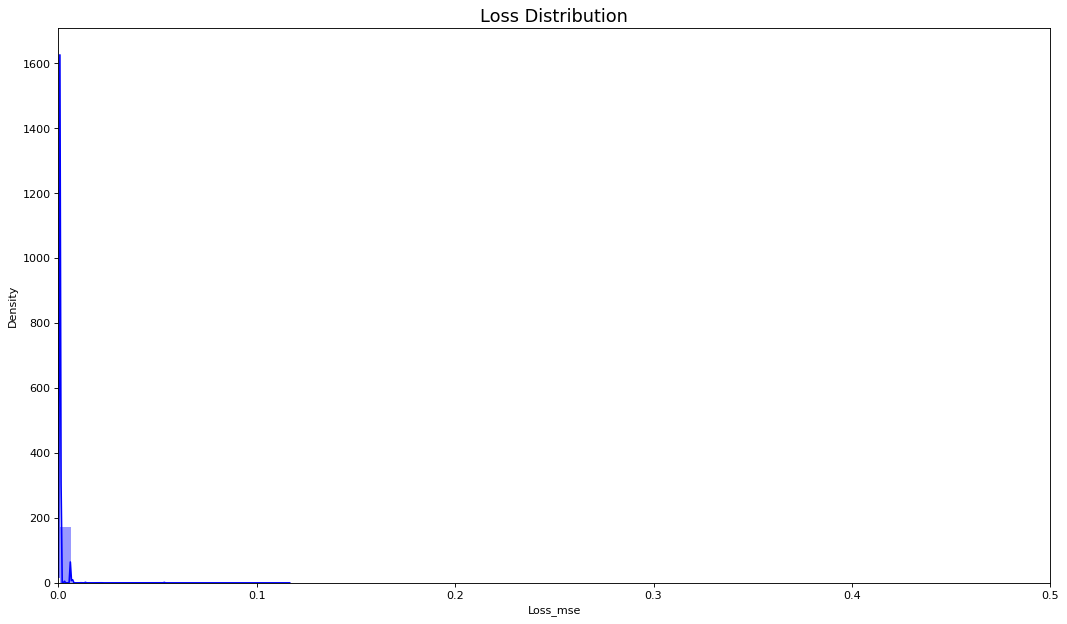

In [ ]:
# plot the loss distribution of the training set
X_pred = model.predict(x_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = x_train.reshape(x_train.shape[0], x_train.shape[2])
scored['Loss_mse'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mse'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [ ]:
# calculate the loss on the test set
X_pred = model.predict(x_out)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=x_out_oh.columns)
X_pred.index = x_out_oh.index

scored = pd.DataFrame(index=x_out_oh.index)
Xtest = x_out.reshape(x_out_oh.shape[0], x_out.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.009
scored['Anomaly'] = np.where(scored['Loss_mae'] > scored['Threshold'], -1, 1)
scored.head()
test_pred = scored.Anomaly


from sklearn.metrics import classification_report
print(classification_report(true_labels, test_pred))

3188/3188 [==============================] - 7s 2ms/step
              precision    recall  f1-score   support

          -1       0.90      0.58      0.70      3737
           1       0.98      1.00      0.99     98263

    accuracy                           0.98    102000
   macro avg       0.94      0.79      0.85    102000
weighted avg       0.98      0.98      0.98    102000



In [ ]:
from pyod.models.copod import COPOD
if __name__ == "__main__":

    # train COPOD detector
    clf_name = 'COPOD'
    clf = COPOD(contamination=0.045)

    # you could try parallel version as well.
    # clf = COPOD(n_jobs=2)
    clf.fit(train)
    pred_test = clf.predict(x_out_oh)

if (pred_test == 1).any():
    pred_test[pred_test == 1] = -1

if (pred_test == 0).any():
    pred_test[pred_test == 0] = 1

Counter(pred_test)

from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_test))

              precision    recall  f1-score   support

          -1       0.04      0.06      0.05      3737
           1       0.96      0.95      0.96     98263

    accuracy                           0.92    102000
   macro avg       0.50      0.50      0.50    102000
weighted avg       0.93      0.92      0.93    102000



In [ ]:
from pyod.models.ecod import ECOD
if __name__ == "__main__":

    # train COPOD detector
    clf_name = 'ECOD'
    clf = ECOD(contamination=0.045)

    # you could try parallel version as well.
    # clf = COPOD(n_jobs=2)
    clf.fit(train)
    pred_test = clf.predict(x_out_oh)

if (pred_test == 1).any():
    pred_test[pred_test == 1] = -1

if (pred_test == 0).any():
    pred_test[pred_test == 0] = 1

Counter(pred_test)

from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_test))

              precision    recall  f1-score   support

          -1       0.05      0.06      0.05      3737
           1       0.96      0.95      0.96     98263

    accuracy                           0.92    102000
   macro avg       0.51      0.51      0.51    102000
weighted avg       0.93      0.92      0.93    102000



In [ ]:
Counter(pred_test)

Counter({1: 97200, -1: 4800})

In [ ]:
clf = IsolationForest(n_estimators=200, contamination = 0.035)

In [ ]:
clf_if_cv = clf.fit(train)

In [ ]:
from joblib import dump, load

# save the model
dump(clf_if_cv,'/content/drive/MyDrive/thesis/models/iforest/clf_if_oh_ae.joblib')

['/content/drive/MyDrive/thesis/models/iforest/clf_if_oh_ae.joblib']

In [ ]:
from joblib import dump, load
clf_if_cv = load('/content/drive/MyDrive/thesis/models/iforest/clf_if_oh_ae.joblib')

In [ ]:
pred_test = clf_if_cv.predict(x_out_oh)

In [ ]:
Counter(pred_test)

Counter({1: 99332, -1: 2668})

In [ ]:
true_labels = df_outlier.label

In [ ]:
df_validate['label'] = pred_test

In [ ]:
df_validate[df_validate['label'] == -1].to_csv('/content/drive/MyDrive/thesis/models/iforest/oh_results_ae_val.csv', index=False)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_test))

              precision    recall  f1-score   support

          -1       0.57      0.41      0.48      3737
           1       0.98      0.99      0.98     98263

    accuracy                           0.97    102000
   macro avg       0.77      0.70      0.73    102000
weighted avg       0.96      0.97      0.96    102000



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have the true labels for the dataset in 'true_labels' and the LOF predictions in 'lof_predictions'

# Convert LOF scores to binary labels based on a threshold (e.g., outliers with scores above the threshold are considered anomalies)

# Calculate accuracy
accuracy = accuracy_score(true_labels, pred_test)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_labels, pred_test)
print("Precision:", precision)

# Calculate recall
recall = recall_score(true_labels, pred_test)
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(true_labels, pred_test)
print("F1 Score:", f1)

Accuracy: 0.9758725490196078
Precision: 0.993113032736257
Recall: 0.9817632272574621
F1 Score: 0.9874055157802082
